<a href="https://colab.research.google.com/github/jamstanleyambe/End-to-End-Dog-Breed-Identification/blob/main/Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐈 End-to-End multil-class Dog Breed Classification

This NoteBook builds an end to end multil-class image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem


> Identifying the bread of a dog given an image of a dog.
if i can take a picture of any dog i want to know what kind of the breed the Dog is.

## 2. Data

>The data we are using is coming from Kaggle dog breed identification competition

## 3. Evaluation

> The Evaluation is a file with prediction probability of each dog breed of each test image

## 4. Features

>Some information about the data:
 * We are dealing with images **(unstructured data)** so it probably best to use deep learning/transfer learning.
 * There are 120 breeds of dogs (this means thee are 120 different classes).
 * There are around 10000 + images in the traing set ( this images has lable beacuse we are using them for the trainig)
 * Tehre are around 10000 + images in the test set, (this images has no lable because we want to predict them)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries for TensorFlow, data manipulation, and visualization
import tensorflow as tf  # Core library for deep learning
import tensorflow_hub as hub  # For using pre-trained models and modules
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced and statistical visualizations
import os  # For interacting with the operating system (e.g., file paths)
import shutil  # For file operations like copying or deleting
import random  # For generating random numbers or shuffling data
from IPython.display import Image  # For displaying images in a Jupyter/Colab environment

# Print versions of TensorFlow and TensorFlow Hub to ensure compatibility
print("tensorflow_hub", hub.__version__)  # Display TensorFlow Hub version
print("tensorflow", tf.__version__)  # Display TensorFlow version

tensorflow_hub 0.16.1
tensorflow 2.17.1


# Getting Our workPace Ready
* import Tensorflow
* import Tensorflow HandleData
* Make sure we're using GPU


In [3]:
# Check if a GPU is available for TensorFlow operations
# This is useful for ensuring that TensorFlow can leverage GPU acceleration, which is critical for deep learning tasks.
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


# getting our data ready (turning into Tensorns)
With all machine learning models, our data has to be in numerical format. So that well be doing first Turning our images into Tensors (numerical representation)

Lets start by accesssing our data and checking out the labels

In [4]:
# Load the dataset labels from a CSV file and inspect the first few rows
# This step helps us understand the structure of the data and verify that it has been loaded correctly.
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/dog-breed-identification/labels.csv")
labels_csv.head()  # Display the first 5 rows of the DataFrame

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# Analyze the structure and summary statistics of the dataset
# These steps provide insights into the dataset's size, data types, missing values, and statistical properties.

# Check the shape of the dataset (number of rows and columns)
print(labels_csv.shape)  # Output: (rows, columns)

# Display information about the dataset, including column names, data types, and non-null counts
print(labels_csv.info())  # Useful for identifying missing values and understanding data types

# Generate descriptive statistics for numerical columns (e.g., count, mean, std, min, max)
print(labels_csv.describe())  # Provides a quick summary of the dataset's numerical features

(10222, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


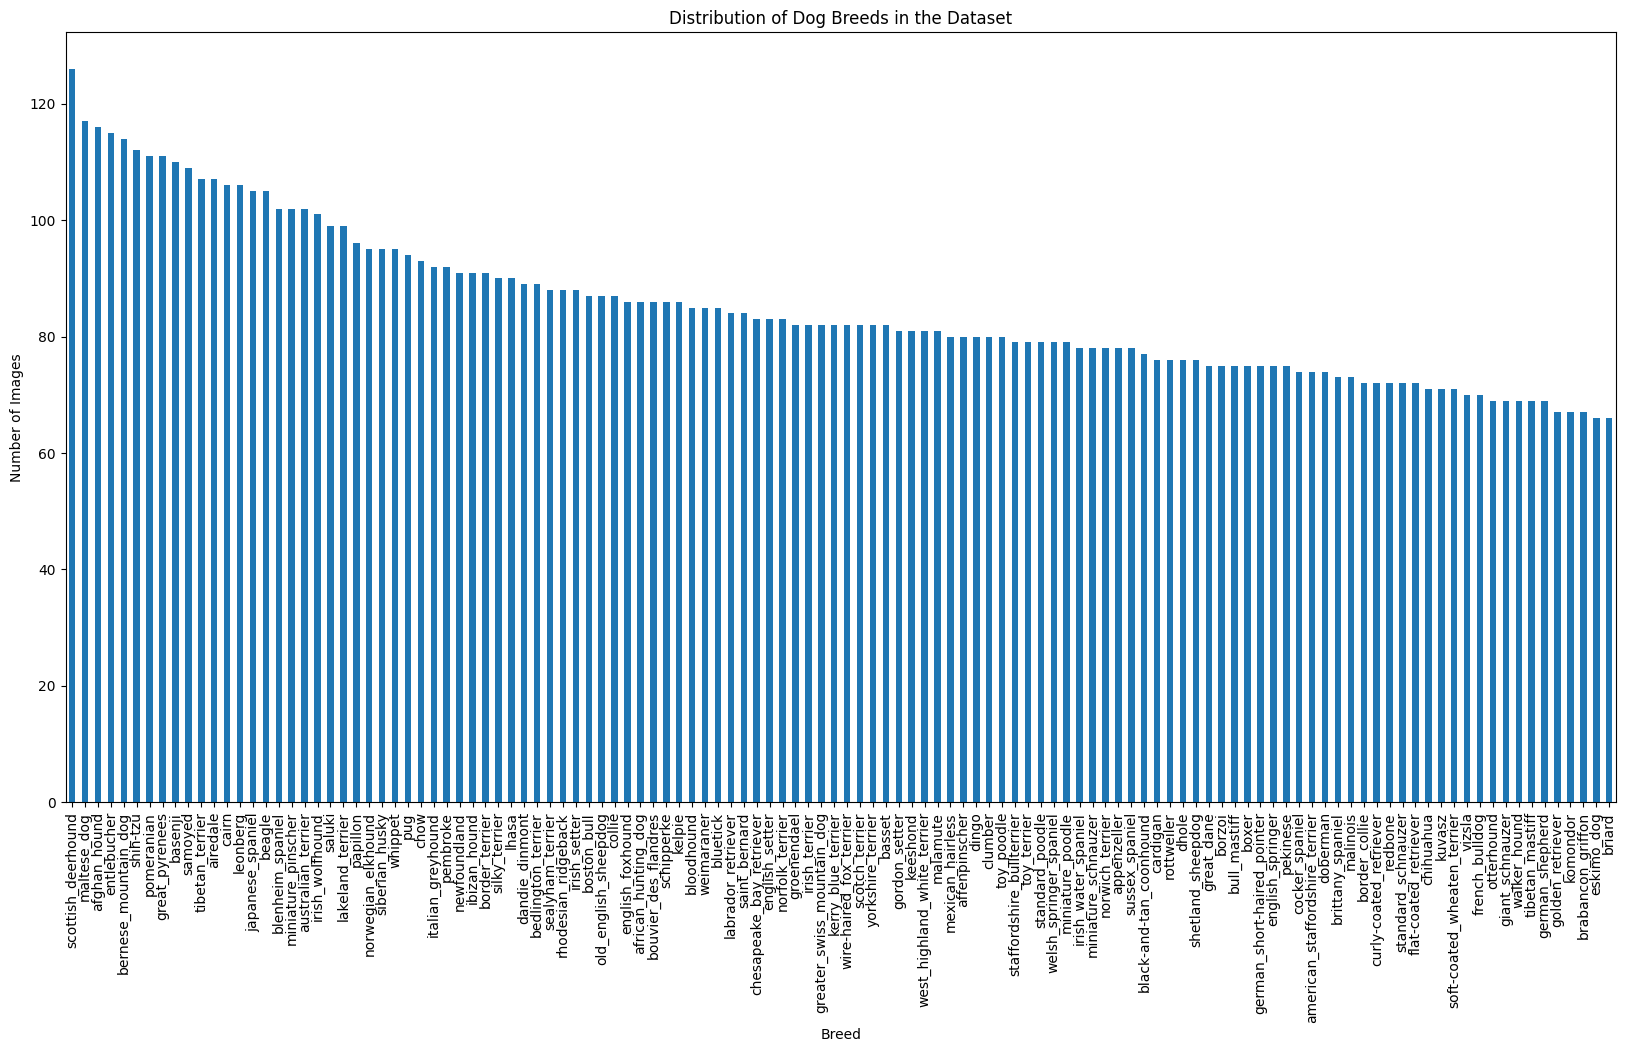

In [6]:
# Visualize the distribution of dog breeds in the dataset
# This step helps us understand the balance (or imbalance) of the dataset by counting and plotting the number of images per breed.

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))  # Create a bar plot of breed counts
plt.xlabel("Breed")  # Label for the x-axis
plt.ylabel("Number of Images")  # Label for the y-axis
plt.title("Distribution of Dog Breeds in the Dataset")  # Title of the plot
plt.show()  # Display the plot

In [7]:
# Calculate the median number of images per breed in the dataset
# This metric provides insight into the central tendency of the dataset's class distribution,
# which is useful for understanding data balance and potential class imbalance issues.

median_images_per_breed = labels_csv['breed'].value_counts().median()
print("Median number of images per breed:", median_images_per_breed)

Median number of images per breed: 82.0


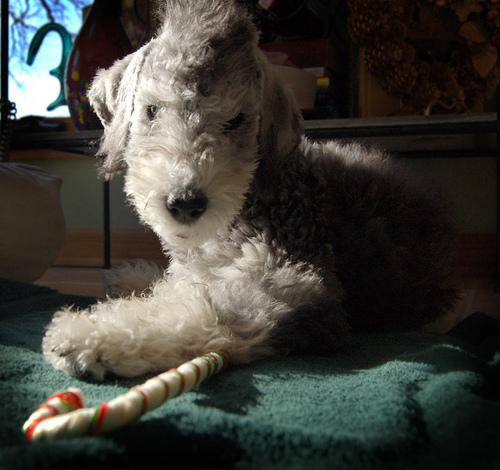

In [8]:
# Display an image from the dataset to visually inspect its content
# This step helps verify that the images are loaded correctly and provides a sense of the data's quality and format.

Image("/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg")

### Getting images and their labels
Let's get a list of all images file and pathnames

In [9]:
# Generate file paths for all images in the dataset using their unique IDs
# This step creates a list of full file paths by combining the base directory with each image's ID and file extension.
# It ensures that we can easily access and load the images for further processing or analysis.

filenames = ['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/' + image_id + '.jpg' for image_id in labels_csv['id']]

In [10]:
# Inspect the first 10 file paths to ensure they have been generated correctly
# This step helps verify that the file paths are properly constructed and match the expected format.

filenames[:10]

['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-

In [11]:
# Check the total number of image file paths generated
# This step ensures that the number of file paths matches the number of images in the dataset,
# helping to confirm that all images have been accounted for.

len(filenames)

10222

In [12]:
# Convert the 'breed' column from the DataFrame into a NumPy array
# This step prepares the labels in a format suitable for machine learning tasks,
# as many libraries (e.g., TensorFlow, scikit-learn) work efficiently with NumPy arrays.

labels = labels_csv['breed'].to_numpy()
labels  # Display the first few entries to verify the conversion

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
# Check the total number of labels in the dataset
# This step ensures that the number of labels matches the number of images,
# confirming that the dataset is complete and ready for further processing.

len(labels)

10222

In [14]:
# Verify that the number of labels matches the number of image file paths
# This step ensures data consistency, confirming that each image has a corresponding label.
# A mismatch could indicate missing or misaligned data, which needs to be addressed before proceeding.

if len(labels) == len(filenames):
    print("Labels match the actual number of files! ✅")  # Success message if counts match
else:
    print("Labels do not match the actual number of files! ❌")  # Warning message if counts mismatch

Labels match the actual number of files! ✅


In [15]:
# Extract and count the unique dog breeds in the dataset
# This step identifies the total number of distinct classes (breeds) in the dataset,
# which is essential for setting up the output layer of a classification model.

unique_breeds = np.unique(labels)  # Extract unique breed names
len(unique_breeds)  # Count the number of unique breeds

120

In [16]:
# Convert a single label into a boolean array indicating its match with unique breeds
# This step is useful for understanding how one-hot encoding works, which is commonly used in classification tasks.

print(labels[0])  # Display the first label for reference
labels[0] == unique_breeds  # Create a boolean array where True indicates a match with the unique breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# Convert all labels into boolean arrays (one-hot encoding equivalent)
# This step transforms each label into a boolean array where the correct breed is marked as True and others as False.
# This format is useful for training machine learning models, especially in multi-class classification tasks.

boolean_labels = [label == np.array(unique_breeds) for label in labels]  # Create boolean arrays for all labels
boolean_labels[:2]  # Display the first two boolean arrays for verification

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [18]:
# Check the total number of boolean label arrays
# This step ensures that the conversion to boolean arrays was successful and that the number of labels matches the dataset size.

len(boolean_labels)

10222

In [19]:
# Demonstrate converting a boolean array back into an integer index
# This step shows how to retrieve the original label index from a boolean array,
# which is useful for interpreting model predictions or reversing one-hot encoding.

print(labels[0])  # Display the first label for reference
print(boolean_labels[0].argmax())  # Find the index of the True value in the boolean array
boolean_labels[0].argmax()  # Return the index (equivalent to the breed's position in unique_breeds)

boston_bull
19


19

In [20]:
# Example Turning boolean array into integers
print(labels[0]) #Original label
print(np.where((unique_breeds == labels[0]))) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 whee the sample label occurs



boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
# Demonstrate converting a boolean array into integers (0s and 1s)
# This step shows how to transform a boolean array into a binary format,
# which is often required for machine learning tasks like one-hot encoding.

print(labels[2])  # Display the third label for reference
print(boolean_labels[2].astype(int))  # Convert the boolean array to integers (True -> 1, False -> 0)

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own Validation set
Since the dataset from Kaggle does not come with a validation set were going to create our own

In [22]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min:1, max:1000}

In [23]:
# Set up X and Y variable
x = filenames
y = boolean_labels

We are going to start off experimenting with ~ 1000 images and increase as need.

In [24]:
# set number of images to use for experimenting
NUM_IMAGES = 1000

In [25]:
#let's Split our data into train and validation sets
from sklearn.model_selection import train_test_split
#split them into training and  validation of total size NUM_IMAGES
x_train, x_test, y_train, y_test = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [26]:
# Check the sizes of the training and testing datasets
# This step ensures that the data has been split correctly and helps verify the distribution of samples.

len(x_train), len(y_train), len(x_test), len(y_test)

(800, 800, 200, 200)

In [27]:
# Inspect the first few samples of the training data and labels
# This step helps verify the content and format of the data, ensuring it is correctly loaded and preprocessed.

x_train[:2], y_train[:2]  # Display the first two samples of features (x) and labels (y)

(['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, 

# Preprocessing images (turuning images into Tensors)
To Preprocessing our images into Tensors we're going to write  a function which does a few things:
1. Take an image filename as input
2. Use TensorFlow to read the file and save it to a variable image
3. Turn our image (a jpg) into Tensors
4. Resize the images to be a shape of (224, 224)
5. Return the modified image

Before we do lets see what importing an images look like

In [28]:
# Coverting image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [29]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

# Now we know how and image looks like as a Tensors, Let's make a function to preprocess them

>1. Take an image filename as input

>2. Use TensorFlow to read the file and save it to a variable image

>3. Turn our image (a jpg) into Tensors

>4. Normalize our image (convert color channel values from 0-255 to 0-1)

>5. Resize the images to be a shape of (224, 224)

>6. Return the modified image

In [30]:
# Dedine image size
IMG_SIZE = 224

#Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  #Read in an images file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into numerical Tensor with 3 colour chanels (Red Green Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (244, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Truning our data into batches
>. Why we turn our data into Batches?
Let's say you are trying to process 10000+ images in one go.... they all might not fit into memeory So that's why we turn them into batches.

> In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: '`(image, label)`

In [31]:
#Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [32]:
testPlt = (process_image(x[42]), y[42])

In [33]:
testPlt

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

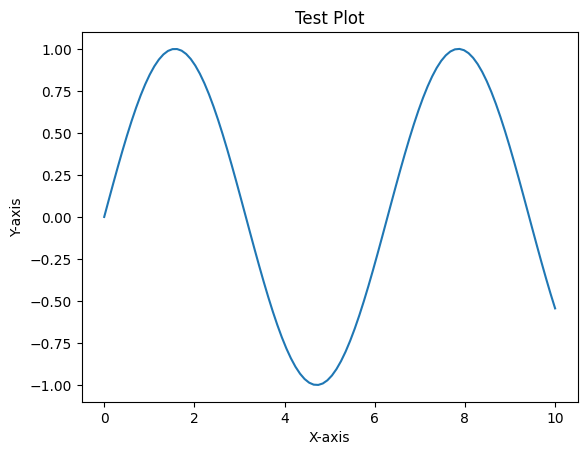

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
testPlt = np.linspace(0, 10, 100)  # Create an array of 100 points

# Plot the data
plt.plot(testPlt, np.sin(testPlt))  # Plot testPlt vs sin(testPlt)
plt.title("Test Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

# Now we've got a way to turn data into tuples of Tensors in the form: `(image, lable)`Let's make a function to turn all of our data (x & y) into Batches!

In [35]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If the data is a training dataset, we need to shuffle it
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function is faster than suffle
    data = data.shuffle(buffer_size=len(x))

    data = data.map(get_image_label)
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data_batch = data.batch(BATCH_SIZE)

    #Turn the training data into batches
    data_batch = data_batch.prefetch(tf.data.AUTOTUNE)
  return data_batch

In [36]:
# Create training and Validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_test, y_test, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [37]:
# Checkout the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
 > Our data is now batches, however, these can be little hard to understand/comprehend, let's Visualize them!

In [38]:
def show_25_images(images, labels, unique_breeds):
    """
    Displays a plot of 25 images and their labels from a data batch.
    Parameters:
        images (numpy array or list): A batch of images (e.g., shape = (25, height, width, channels)).
        labels (numpy array or list): Corresponding labels for the images (one-hot encoded or integer labels).
        unique_breeds (list): A list of unique breed names corresponding to the labels.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        if len(labels[i].shape) == 1:  # If labels are one-hot encoded
            breed_index = labels[i].argmax()  # Get the index of the maximum value
        else:  # If labels are already integers
            breed_index = labels[i]
        plt.title(unique_breeds[breed_index])  # Use the index to get the breed name
        # Turn the grid lines off
        plt.axis("off")
    # Show the plot
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [39]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images[2], train_labels[2]

(array([[[0.5569949 , 0.5384959 , 0.49817133],
         [0.6884234 , 0.71680236, 0.62273675],
         [0.5859472 , 0.68662465, 0.54352164],
         ...,
         [0.71210116, 0.7199443 , 0.77092475],
         [0.615056  , 0.6286065 , 0.69191176],
         [0.667256  , 0.6907854 , 0.7524685 ]],
 
        [[0.35854644, 0.35565728, 0.29975742],
         [0.8856503 , 0.9028444 , 0.8118048 ],
         [0.45538545, 0.55437005, 0.40149814],
         ...,
         [0.6099464 , 0.61778957, 0.6648484 ],
         [0.6904091 , 0.70570934, 0.7527336 ],
         [0.7050957 , 0.7182259 , 0.7721647 ]],
 
        [[0.44953   , 0.4642709 , 0.38830802],
         [0.42991978, 0.48215908, 0.3516627 ],
         [0.43982825, 0.53282547, 0.370697  ],
         ...,
         [0.6899745 , 0.7008113 , 0.7388891 ],
         [0.6755564 , 0.68667495, 0.7246119 ],
         [0.6673771 , 0.67339355, 0.71721953]],
 
        ...,
 
        [[0.8568963 , 0.8529747 , 0.8333669 ],
         [0.8332656 , 0.82934403, 0.80973

In [40]:
len(train_images), len(train_labels)

(32, 32)

#Now Let's Visualize Our Data In The Training Batch!

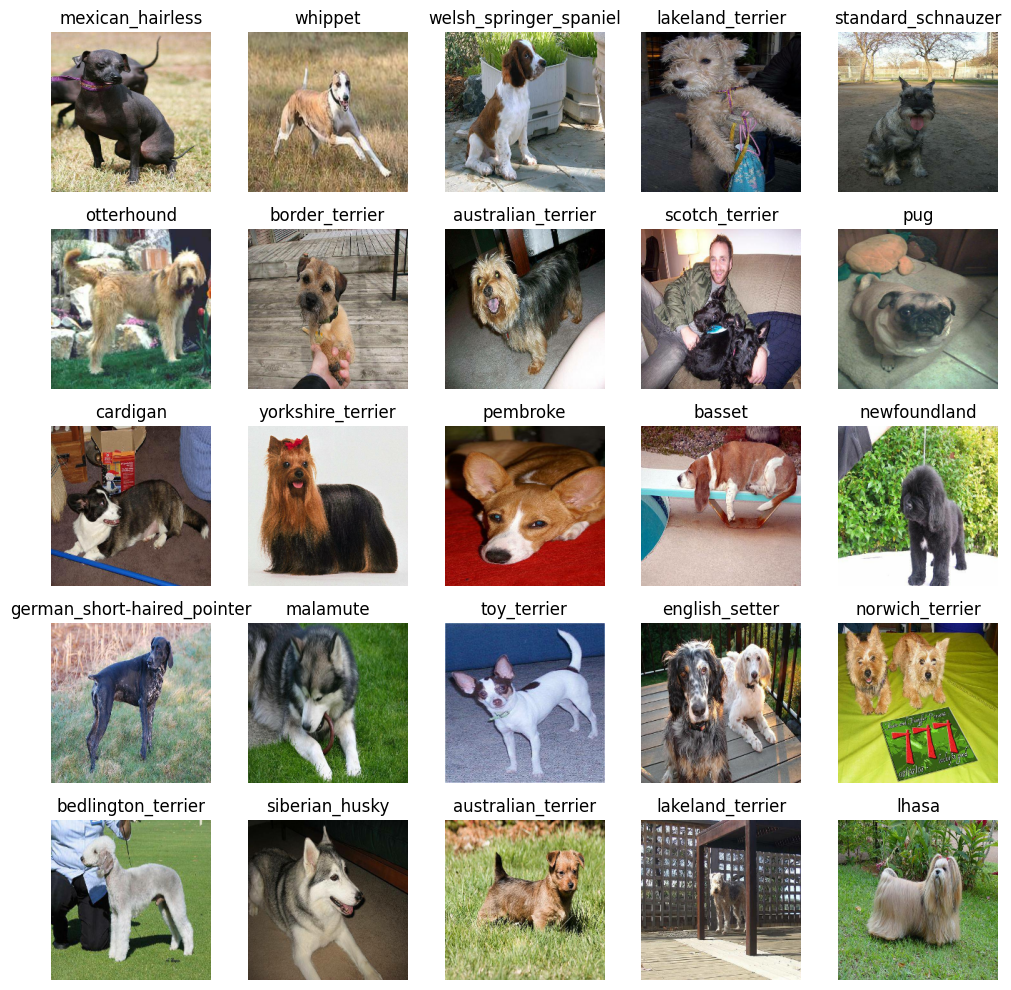

In [41]:
show_25_images(train_images, train_labels, unique_breeds)

# Building a model
Before we build a model, there few thing we need to define

* The input Shape (Our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors ) of our model
* The Url of the model we want to use

In [43]:
# Setup input Shape to the modle
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup Output Shape of our model
OUTPUT_SHAPE = len(unique_breeds) # number of unique breeds in our dataset

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now that we have input, output and model ready to go.
Let's put them together into a Keras deep learning model
.....
Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we have chosen as parameters.
* Definethe layers in a Keras model in sequential fashion (do this first,  then that)/
* Compiles themodel (say how it should be evaluated and how it should be improved
* Build the model (tells the model the input shape it will be getting )
* Returns the model